# Predicting The Ratings

## Table of Contents

* [Load Data](#Load-Data)
* [Functions](#Functions)
* [Model Function](#Model-Function)
* [PFI Function](#PFI)
* [Training and testing the models](#Training-and-testing-the-model)
* [Predict Fifa23 Data](#Predict-Fifa23-Data)
* [Results](#Results)
* [Feature Importance](#Feature-Importance)

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor


Data Path 

In [2]:
folder = f"Dataset\After-PreProcess\predict-by-rating"

In [3]:
g_folder = f"Dataset\After-PreProcess\predict-with-real-life-stats"

## Load Data

In [4]:
## Ratings With Stats
g_fielders = pd.read_csv(g_folder+"/stats_Full_df.csv")
g_keepers = pd.read_csv(g_folder+"/stats_gk_df.csv")
g_defenders = pd.read_csv(g_folder+"/stats_defenders_df.csv")
stats_forward_df = pd.read_csv(g_folder+"/stats_forward_df.csv")
stats_midfielders_df = pd.read_csv(g_folder+"/stats_midfielders_df.csv")

In [5]:
## Fifa 23 Ratings With STATS 
g_stats_midfielders_df_f23 = pd.read_csv(g_folder+"/f23-stats_midfielders_df.csv")
g_stats_forward_df_f23 = pd.read_csv(g_folder+"/f23-stats_forward_df.csv")
g_defenders_f23 = pd.read_csv(g_folder+"/f23-stats_defenders_df.csv")

In [6]:
defenders_df23 = pd.read_csv(folder+"/f23-defenders_df.csv")
forward_df23 = pd.read_csv(folder+"/f23-forward_df.csv")
gk_df23 = pd.read_csv(folder+"/f23-gk_df.csv")
midfielders_df23 = pd.read_csv(folder+"/f23-midfielders_df.csv")


In [7]:
gk_df =pd.read_csv(folder+"/defenders_df.csv")
defenders_df=pd.read_csv(folder+"/defenders_df.csv")
midfielders_df=pd.read_csv(folder+"/defenders_df.csv")
forward_df= pd.read_csv(folder+"/defenders_df.csv")

## Functions

In [8]:
def drop_not_needed_fields(df , position_group):
    if position_group == "defenders":
        df = df.drop(['Unnamed: 0', 'Next_Year_Club','GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Position',  'Name' , 'Club', "Work Rate", "Positioning", "Position",
                     "Height", "Weight" , "Next_Year_Club"],axis = 1)
    elif position_group == "midfielders":
        df = df.drop(['Unnamed: 0', 'Next_Year_Club','GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Position',  'Name' , 'Club', "Work Rate", "Positioning", "Position",
                     "Height", "Weight" , "Next_Year_Club"],axis = 1)
    elif position_group == "forwards":
        df = df.drop(['Unnamed: 0', 'Next_Year_Club','GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Position',  'Name' , 'Club', "Work Rate", "Positioning", "Position",
                     "Height", "Weight" , "Next_Year_Club"],axis = 1)   
    elif  position_group == "goalkeepers":
        df = df.drop(['Unnamed: 0', 'Next_Year_Club', 'Best Position',  'Name' , 'Club', "Work Rate", "Positioning", "Position",
                     "Height", "Weight" , "Next_Year_Club",
                     'Crossing', 'Finishing','HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 'Agility', 'Reactions', 'Balance', 'ShotPower',
                       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
                       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
                       'StandingTackle', 'DefensiveAwareness'],axis = 1)
    return df

In [9]:
def split_df(df, test_size=0.25, random_state=42):
    """Splits a Pandas dataframe into train and test sets.

    Args:
    df: The Pandas dataframe to split.
    test_size: The size of the test set, as a fraction of the total dataset.
    random_state: The random state to use for shuffling the data.

    Returns:
    A tuple of train and test dataframes.
    """

    # Shuffle the data.
    df = df.sample(frac=1, random_state=random_state)

    # Split the data into train and test sets.
    train_size = int(len(df) * (1 - test_size))
    train_df = df[:train_size]
    test_df = df[train_size:]

    return train_df, test_df


In [10]:
def get_features(position_group):
    if position_group == "defenders":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle']
    elif position_group == "midfielders":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle']
    elif position_group == "forwards":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle']
    elif  position_group == "goalkeepers":
        return ['GKDiving', 'GKHandling','GKKicking', 'GKPositioning', 'GKReflexes','Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Acceleration','SprintSpeed']
        

In [11]:
# Direction functions
def analyze_movement_direction(df):
    same_count = 0
    higher_count = 0
    lower_count = 0

    for _, row in df.iterrows():
        next_overall = row['Next_Overall']
        prediction = row['predictions']

        if prediction > next_overall:
            higher_count += 1
        elif prediction < next_overall:
            lower_count += 1
        else:
            same_count += 1

    result = {
        'Predicted Right': same_count,
        'Predicted Higher': higher_count,
        'Predicted Lower': lower_count
    }

    return result


In [12]:
def analyze_movement(df):
    total_count = len(df)
    move_up_count = 0
    move_down_count = 0
    pred_move_up_count = 0
    pred_move_down_count = 0
    pred_same = 0
    same = 0
    for _, row in df.iterrows():
        overall = row['Overall']
        next_overall = row['Next_Overall']
        prediction = row['predictions']

        if next_overall > overall:
            move_up_count += 1
            if prediction > overall:
                pred_move_up_count += 1
        elif next_overall < overall:
            move_down_count += 1
            if prediction < overall:
                pred_move_down_count += 1
        else:
            same += 1
            if prediction == overall:
                pred_same += 1

    result = {
        'Total Rows': total_count,
        'Moved Up': move_up_count,
        'Predicted Move Up': pred_move_up_count,
        'Moved Down': move_down_count,
        'Predicted Move Down': pred_move_down_count,
        'Stayed the Same': same,
        'Predicted to Stay the Same': pred_same
    }

    return result


In [13]:
def generate_prediction_report(df):
    diff_counts = {'Exactly': 0,'Off by 1': 0, 'Off by 2': 0,'Off by 3': 0, 'Off by 4 or more': 0}

    for _, row in df.iterrows():
        next_overall = row['Next_Overall']
        prediction = row['predictions']
        diff = abs(next_overall - prediction)

        if diff == 1:
            diff_counts['Off by 1'] += 1
        elif diff == 2:
            diff_counts['Off by 2'] += 1
        elif diff == 3:
            diff_counts['Off by 3'] += 1
        elif diff >= 4:
            diff_counts['Off by 4 or more'] += 1
        else:
            diff_counts['Exactly'] += 1

    return diff_counts


In [14]:
def get_features_with_goals(position_group):
    if position_group == "defenders":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG',
       'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1',
       'npxG+xAG.1']
    elif position_group == "midfielders":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG',
       'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1',
       'npxG+xAG.1']
    elif position_group == "forwards":
        return ['Age', 'Overall', 'Potential' , 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG',
       'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1',
       'npxG+xAG.1']
    elif  position_group == "goalkeepers":
        return


In [15]:
import pandas as pd

def calculate_change(df, field1, field2, new_field):
    df[new_field] = pd.NA
    df.loc[df[field2] > df[field1], new_field] = "Improvement"
    df.loc[df[field2] == df[field1], new_field] = "Staying the same"
    df.loc[df[field2] < df[field1], new_field] = "Decline"
    return df


In [16]:
import matplotlib.pyplot as plt

def bar(dictionary):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(dictionary)), list(dictionary.values()), align='center')
    plt.xticks(range(len(dictionary)), list(dictionary.keys()))
    plt.show()



In [17]:
def create_pie_chart(data_dict):
    keys = list(data_dict.keys())
    values = list(data_dict.values())

    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=keys, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.show()


In [18]:
import matplotlib.pyplot as plt

def plot_bar_chart(dictionary , title):
    """
    Plots a bar chart with vertical labels from a dictionary.

    Args:
    dictionary: A dictionary where the keys are the labels and the values are the values for the bars.

    Returns:
    None.
    """
    # Get the labels and values from the dictionary.
    labels = list(dictionary.keys())
    values = list(dictionary.values())
    plt.figure(figsize=(12, 6))
    # Plot the bar chart.
    plt.bar(labels, values)

    # Set the labels to be vertical.
    plt.xticks(rotation=90)
    plt.title(title)

    # Show the plot.
    plt.show()


In [19]:
def calculate_delta(df, field1, field2, new_field):
    df[new_field] = defenderswithpredictions[field1]-defenderswithpredictions[field2]
    return df

In [20]:
import numpy as np

def calculate_average_delta(df):
    predictions = df['predictions']
    next_overall = df['Next_Overall']

    # Calculate the deltas
    deltas = np.abs(predictions - next_overall)

    # Calculate the average delta and standard deviation
    average_delta = np.mean(deltas)
    std_dev = np.std(deltas)

    return average_delta, std_dev

In [21]:
def accuracy_of_trend(df):
    df = calculate_change(df.copy() ,"Overall", "Next_Overall" , "real_trend")
    df = calculate_change(df.copy() ,"Overall", "predictions" , "predicted_trend")
    print("accuracy of trend: ", accuracy_score(df["real_trend"], df["predicted_trend"]))
    return df

In [22]:
def predict_new_data(model , new_data , features):
    
    imputer = SimpleImputer(strategy='mean')
    X_test = new_data[features].copy()
    X_test_imputed = imputer.fit_transform(X_test)
    y_pred = model.predict(X_test_imputed)
    # Add the predictions to the dataframe in a column
    new_data['Next_Overall'] = np.round(y_pred).astype(int)
    return new_data

In [23]:
column_mapping = {
    'Heading Accuracy':'HeadingAccuracy',
    'Sprint Speed':'SprintSpeed',
    'Known As': 'Name',
    'Positions Played': 'Position',
    'Image Link': 'ID',
    'Club Name': 'Club',
    'Club Position': 'Position',
    'Contract Until': 'Contract',
    'Club Jersey Number': 'Jersey Number',
    'Preferred Foot': 'Foot',
    'Weak Foot Rating': 'Weak Foot',
    'Shot Power':'ShotPower',
    'Long Shots':'LongShots',
    'Standing Tackle':'StandingTackle',
    'Sliding Tackle':'SlidingTackle',
    'Short Passing':'ShortPassing', 
    'Freekick Accuracy':'FKAccuracy', 
}


In [24]:
def rename_columns(df_f23, df_f22 , column_mapping):
    renamed_columns = []
    for column in df_f23.columns:
        if column in column_mapping:
            renamed_columns.append(column_mapping[column])
        else:
            renamed_columns.append(column)
    
    df_f23.columns = renamed_columns
    
    return df_f23


## Model Function

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer


def run_model(df, features, model_type = "Random Forest"):   
    train_df, test_df = split_df(df)
    
    y_train = train_df['Next_Overall']
    y_test = test_df['Next_Overall']
    
    X_train = train_df[features].copy()
    X_test = test_df[features].copy()

    # Create a SimpleImputer to handle missing values
    imputer = KNNImputer()

    # Impute missing values in training data
    X_train_imputed = imputer.fit_transform(X_train)

    # Impute missing values in testing data
    X_test_imputed = imputer.transform(X_test)

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    }

    # Create the Random Forest Regression model
    if model_type.lower() == "xgboost":
        model = XGBRegressor()
    else:   
        model = RandomForestRegressor(random_state=42)

    # Perform grid search to find the best model
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_imputed, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    best_model.fit(X_train_imputed, y_train)
    # Make predictions on the test set
    y_pred = np.round(best_model.predict(X_test_imputed))

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)

    # Compute permutation feature importance
    result = permutation_feature_importance(best_model, X_test_imputed, y_test, n_repeats=10, random_state=42)
    feature_importance = {feature: importance for feature, importance in zip(features, result.importances_mean)}

    # Train the model with adjusted weights

    # Add the predictions to the dataframe in a column
    test_df['predictions'] = np.round(best_model.predict(X_test_imputed)).astype(int)
    test_df['Next_Overall'] = test_df['Next_Overall'].astype(int)
    print(f'Best Model Accuracy: {accuracy}')
    
    # Return the best model, test dataframe, feature importance, and best weight set
    return best_model, test_df, feature_importance


## PFI

In [26]:
def permutation_feature_importance(model, df, num_iterations=100):
    """
    Perform Permutation Feature Importance on a trained random forest model.

    Parameters:
        - model: Trained random forest model
        - X: Input features
        - y: Target variable
        - num_iterations: Number of iterations for permutation

    Returns:
        - feature_importances: Dictionary of feature importances
    """
    train_df, test_df = split_df(df)

    y_train = train_df['Next_Overall']
    y = test_df['Next_Overall']
    
    # Calculate the baseline score
    baseline_score = accuracy_score(y, model.predict(X))

    # Initialize an empty dictionary to store feature importances
    feature_importances = {}

    # Iterate over each feature
    for feature in X.columns:
        # Make a copy of the original feature values
        X_permuted = X.copy()

        # Permute the values of the current feature
        X_permuted[feature] = np.random.permutation(X_permuted[feature])

        # Calculate the score after permuting the feature
        permuted_score = metric(y, model.predict(X_permuted))

        # Calculate the feature importance as the difference between the baseline score and permuted score
        feature_importance = baseline_score - permuted_score

        # Store the feature importance in the dictionary
        feature_importances[feature] = feature_importance

    return feature_importances


## Model Report

In [27]:
def report_results(results_df):
    accuracy_of_trend(results_df.copy())
    average_delta ,std_dev = calculate_average_delta(results_df.copy())
    print("average delta of prediction from Next Overall: ",average_delta)
    print("standard deviation: ",std_dev)
    create_pie_chart(generate_prediction_report(results_df.copy()))

## Training and testing the model

Random Forest

In [ ]:
model_def , defenderswithpredictions , def_pfi  = run_model(defenders_df.copy(), get_features("defenders"))

In [ ]:
report_results(defenderswithpredictions)

In [ ]:
model_mid, midsswithpredictions, mid_pfi  = run_model(midfielders_df.copy(), get_features("midfielders"))

In [ ]:
report_results(midsswithpredictions)

In [ ]:
model_fw, fwwithpredictions, fwd_pfi = run_model(forward_df.copy() , get_features("forwards"))

In [ ]:
report_results(fwwithpredictions)

XGBoost

In [ ]:
xgmodel_def , xgdefenderswithpredictions , xgdef_pfi  = run_model(defenders_df.copy(), get_features("defenders"), model_type ="xgboost")

In [ ]:
report_results(xgdefenderswithpredictions)

In [ ]:
xgmodel_mid, xgmidsswithpredictions, xgmid_pfi  = run_model(midfielders_df.copy(), get_features("midfielders"), model_type ="xgboost")

In [ ]:
report_results(xgmidsswithpredictions)

In [ ]:
xgmodel_fw, xgfwwithpredictions, xgfwd_pfi = run_model(forward_df.copy() , get_features("forwards"), model_type ="xgboost")

In [ ]:
report_results(xgfwwithpredictions)

## With Stats

Random Forest

In [ ]:
model_defenders_g , defenderswithpredictions_g , def_pfi_g  = run_model(g_defenders.copy(), get_features_with_goals("defenders"))

In [ ]:
report_results(defenderswithpredictions_g)

In [ ]:
model_mids_g , midswithpredictions_g, mid_pfi_g  = run_model(stats_midfielders_df.copy(), get_features_with_goals("defenders"))

In [ ]:
report_results(midswithpredictions_g)

In [ ]:
model_forwards_g , forwardswithpredictions_g, fw_pfi_g  = run_model(stats_forward_df.copy(), get_features_with_goals("defenders"))

In [ ]:
report_results(forwardswithpredictions_g)

XGBoost

In [ ]:
xgmodel_defenders_g , xgdefenderswithpredictions_g , xgdef_pfi_g  = run_model(g_defenders.copy(), get_features_with_goals("defenders"),model_type ="xgboost")

In [ ]:
report_results(xgdefenderswithpredictions_g)

In [ ]:
xgmodel_mids_g , xgmidswithpredictions_g, xgmid_pfi_g  = run_model(stats_midfielders_df.copy(), get_features_with_goals("defenders"),model_type ="xgboost")

In [ ]:
report_results(xgmidswithpredictions_g)

In [ ]:
xgmodel_forwards_g , xgforwardswithpredictions_g, xgfw_pfi_g  = run_model(stats_forward_df.copy(), get_features_with_goals("defenders"),model_type ="xgboost")

report_results(xgforwardswithpredictions_g)

### Predict Fifa23 Data

In [ ]:
defenders_df23 = rename_columns(defenders_df23 , defenders_df , column_mapping)

In [ ]:
midfielders_df23 = rename_columns(midfielders_df23 , midfielders_df , column_mapping)

In [ ]:
forward_df23 = rename_columns(forward_df23 , forward_df , column_mapping)

In [ ]:
g_stats_midfielders_df_f23 = rename_columns(g_stats_midfielders_df_f23 , midfielders_df , column_mapping)
g_stats_forward_df_f23 = rename_columns(g_stats_forward_df_f23 , forward_df , column_mapping)
g_defenders_f23 = rename_columns(g_defenders_f23 , defenders_df , column_mapping)

Predicted fifa 23 data

In [ ]:
predicted_df_def = predict_new_data(model_def , defenders_df23.copy() , get_features("defenders"))

In [ ]:
predicted_df_mid = predict_new_data(model_mid , midfielders_df23.copy()  , get_features("midfielders"))

In [ ]:
predicted_df_fw = predict_new_data(model_fw , forward_df23.copy() , get_features("forwards"))

XGBoost

In [ ]:
xgpredicted_df_def = predict_new_data(xgmodel_def , defenders_df23.copy() , get_features("defenders"))

In [ ]:
xgpredicted_df_mid = predict_new_data(xgmodel_mid , midfielders_df23.copy()  , get_features("midfielders"))

In [ ]:
xgpredicted_df_fw = predict_new_data(xgmodel_fw , forward_df23.copy() , get_features("forwards"))

With goals

In [ ]:
predicted_df_def_g = predict_new_data(model_defenders_g , g_defenders_f23.copy() , get_features_with_goals("defenders"))

In [ ]:
predicted_df_mid_g = predict_new_data(model_mids_g , g_stats_midfielders_df_f23.copy() , get_features("midfielders"))

In [ ]:
predicted_df_fw_g = predict_new_data(model_forwards_g , g_stats_forward_df_f23.copy() , get_features("forwards"))

XGBoost

In [ ]:
xgpredicted_df_def_g = predict_new_data(xgmodel_defenders_g , g_defenders_f23.copy() , get_features_with_goals("defenders"))

In [ ]:
xgpredicted_df_mid_g = predict_new_data(xgmodel_mids_g , g_stats_midfielders_df_f23.copy() , get_features("midfielders"))

In [ ]:
xgpredicted_df_fw_g = predict_new_data(xgmodel_forwards_g , g_stats_forward_df_f23.copy() , get_features("forwards"))

## Results

In [53]:
predicted_df_def[["Name","ID","Overall","predictions","Next_Overall"]].head()

,Name,ID,Overall,predictions,Next_Overall
0,V. van Dijk,https://cdn.sofifa.net/players/203/376/23_60.png,90,59,89
1,Rúben Dias,https://cdn.sofifa.net/players/239/818/23_60.png,88,58,88
2,João Cancelo,https://cdn.sofifa.net/players/210/514/23_60.png,88,58,88
3,Marquinhos,https://cdn.sofifa.net/players/207/865/23_60.png,88,59,89
4,A. Rüdiger,https://cdn.sofifa.net/players/205/452/23_60.png,87,58,88
5,A. Robertson,https://cdn.sofifa.net/players/216/267/23_60.png,87,58,88
6,K. Koulibaly,https://cdn.sofifa.net/players/201/024/23_60.png,87,58,88
7,D. Alaba,https://cdn.sofifa.net/players/197/445/23_60.png,86,58,88
8,Thiago Silva,https://cdn.sofifa.net/players/164/240/23_60.png,86,58,88
9,A. Laporte,https://cdn.sofifa.net/players/212/218/23_60.png,86,58,88


In [54]:
predicted_df_def_g[["Name","ID","Overall","predictions","Next_Overall"]].head(20)

,Name,Name,ID,Overall,predictions,Next_Overall
0,V. van Dijk,V. van Dijk,https://cdn.sofifa.net/players/203/376/23_60.png,90,57,87
1,Rúben Dias,Rúben Dias,https://cdn.sofifa.net/players/239/818/23_60.png,88,57,87
2,João Cancelo,João Cancelo,https://cdn.sofifa.net/players/210/514/23_60.png,88,57,87
3,A. Robertson,A. Robertson,https://cdn.sofifa.net/players/216/267/23_60.png,87,57,87
4,K. Koulibaly,K. Koulibaly,https://cdn.sofifa.net/players/201/024/23_60.png,87,57,87
5,Thiago Silva,Thiago Silva,https://cdn.sofifa.net/players/164/240/23_60.png,86,56,86
6,A. Laporte,A. Laporte,https://cdn.sofifa.net/players/212/218/23_60.png,86,56,86
7,M. Škriniar,M. Škriniar,https://cdn.sofifa.net/players/232/363/23_60.png,86,56,86
8,K. Walker,K. Walker,https://cdn.sofifa.net/players/188/377/23_60.png,85,56,86
9,S. de Vrij,S. de Vrij,https://cdn.sofifa.net/players/198/176/23_60.png,84,56,86


In [55]:
predicted_df_mid[["Name","ID","Overall","predictions","Next_Overall"]].head(20)

,Name,ID,Overall,predictions,Next_Overall
0,L. Messi,https://cdn.sofifa.net/players/158/023/23_60.png,91,57,87
1,K. De Bruyne,https://cdn.sofifa.net/players/192/985/23_60.png,91,58,88
2,Casemiro,https://cdn.sofifa.net/players/200/145/23_60.png,89,58,88
3,S. Mané,https://cdn.sofifa.net/players/208/722/23_60.png,89,58,88
4,J. Kimmich,https://cdn.sofifa.net/players/212/622/23_60.png,89,58,88
5,N. Kanté,https://cdn.sofifa.net/players/215/914/23_60.png,89,58,88
6,Bernardo Silva,https://cdn.sofifa.net/players/218/667/23_60.png,88,58,88
7,T. Kroos,https://cdn.sofifa.net/players/182/521/23_60.png,88,58,88
8,L. Modrić,https://cdn.sofifa.net/players/177/003/23_60.png,88,57,87
9,Rodri,https://cdn.sofifa.net/players/231/866/23_60.png,87,58,88


In [56]:
predicted_df_mid_g[["Name","ID","Overall","predictions","Next_Overall"]].head(30)

,Name,Name,ID,Overall,predictions,Next_Overall
0,K. De Bruyne,K. De Bruyne,https://cdn.sofifa.net/players/192/985/23_60.png,91,60,90
1,Arthur,Arthur,https://cdn.sofifa.net/players/230/658/23_60.png,80,58,88
2,N. Kanté,N. Kanté,https://cdn.sofifa.net/players/215/914/23_60.png,89,59,89
3,Bernardo Silva,Bernardo Silva,https://cdn.sofifa.net/players/218/667/23_60.png,88,59,89
4,Rodri,Rodri,https://cdn.sofifa.net/players/231/866/23_60.png,87,59,89
5,Fabinho,Fabinho,https://cdn.sofifa.net/players/209/499/23_60.png,87,59,89
6,T. Alexander-Arnold,T. Alexander-Arnold,https://cdn.sofifa.net/players/231/281/23_60.png,87,59,89
7,P. Dybala,P. Dybala,https://cdn.sofifa.net/players/211/110/23_60.png,86,59,89
8,M. Brozović,M. Brozović,https://cdn.sofifa.net/players/216/352/23_60.png,86,59,89
9,N. Barella,N. Barella,https://cdn.sofifa.net/players/224/232/23_60.png,86,59,89


In [57]:
predicted_df_fw[["Name","ID","Overall","predictions","Next_Overall"]].head(20)

,Name,ID,Overall,predictions,Next_Overall
0,K. Benzema,https://cdn.sofifa.net/players/165/153/23_60.png,91,58,88
1,R. Lewandowski,https://cdn.sofifa.net/players/188/545/23_60.png,91,58,88
2,K. Mbappé,https://cdn.sofifa.net/players/231/747/23_60.png,91,58,88
3,M. Salah,https://cdn.sofifa.net/players/209/331/23_60.png,90,58,88
4,Cristiano Ronaldo,https://cdn.sofifa.net/players/020/801/23_60.png,90,58,88
5,H. Kane,https://cdn.sofifa.net/players/202/126/23_60.png,89,58,88
6,Neymar Jr,https://cdn.sofifa.net/players/190/871/23_60.png,89,58,88
7,H. Son,https://cdn.sofifa.net/players/200/104/23_60.png,89,58,88
8,E. Haaland,https://cdn.sofifa.net/players/239/085/23_60.png,88,58,88
9,C. Immobile,https://cdn.sofifa.net/players/192/387/23_60.png,86,58,88


In [58]:
predicted_df_fw_g[["Name","ID","Overall","predictions","Next_Overall"]].head(20)

,Name,Name,ID,Overall,predictions,Next_Overall
0,M. Salah,M. Salah,https://cdn.sofifa.net/players/209/331/23_60.png,90,59,89
1,E. Haaland,E. Haaland,https://cdn.sofifa.net/players/239/085/23_60.png,88,57,87
2,C. Immobile,C. Immobile,https://cdn.sofifa.net/players/192/387/23_60.png,86,56,86
3,R. Lukaku,R. Lukaku,https://cdn.sofifa.net/players/192/505/23_60.png,86,56,86
4,R. Sterling,R. Sterling,https://cdn.sofifa.net/players/202/652/23_60.png,86,57,87
5,R. Mahrez,R. Mahrez,https://cdn.sofifa.net/players/204/485/23_60.png,86,56,86
6,L. Martínez,L. Martínez,https://cdn.sofifa.net/players/231/478/23_60.png,86,58,88
7,P. Aubameyang,P. Aubameyang,https://cdn.sofifa.net/players/188/567/23_60.png,85,56,86
8,J. Vardy,J. Vardy,https://cdn.sofifa.net/players/208/830/23_60.png,85,56,86
9,Diogo Jota,Diogo Jota,https://cdn.sofifa.net/players/224/458/23_60.png,85,57,87


XGBoost

In [ ]:
xgpredicted_df_def[["Name","ID","Overall","predictions","Next_Overall"]].head()

In [ ]:
xgpredicted_df_def_g[["Name","ID","Overall","predictions","Next_Overall"]].head(20)

In [ ]:
xgpredicted_df_mid[["Name","ID","Overall","predictions","Next_Overall"]].head(20)

In [ ]:
xgpredicted_df_mid_g[["Name","ID","Overall","predictions","Next_Overall"]].head(30)

In [ ]:
xgpredicted_df_fw[["Name","ID","Overall","predictions","Next_Overall"]].head(20)

In [ ]:
xgpredicted_df_fw_g[["Name","ID","Overall","predictions","Next_Overall"]].head(20)

## Feature Importance

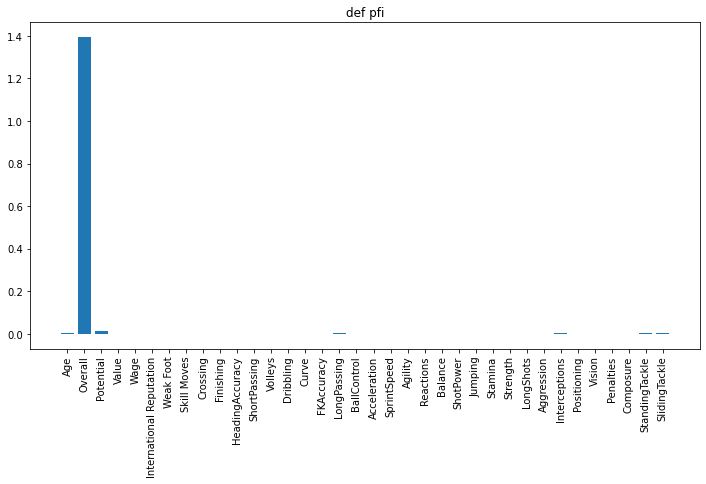

In [62]:
plot_bar_chart(def_pfi , "def pfi")

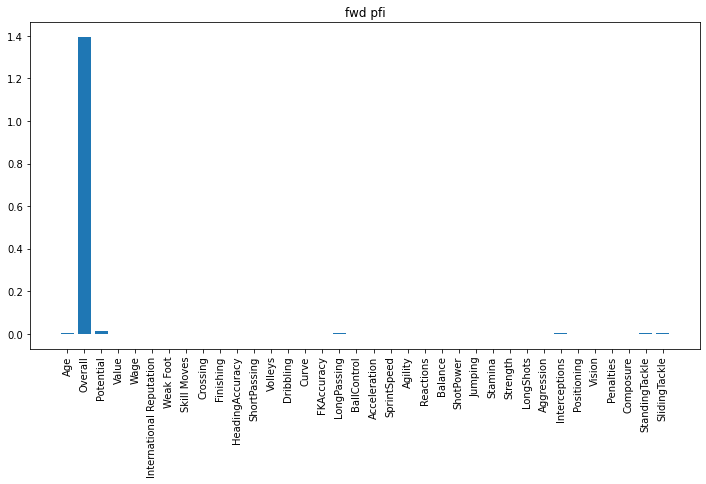

In [63]:
plot_bar_chart(fwd_pfi, "fwd pfi")

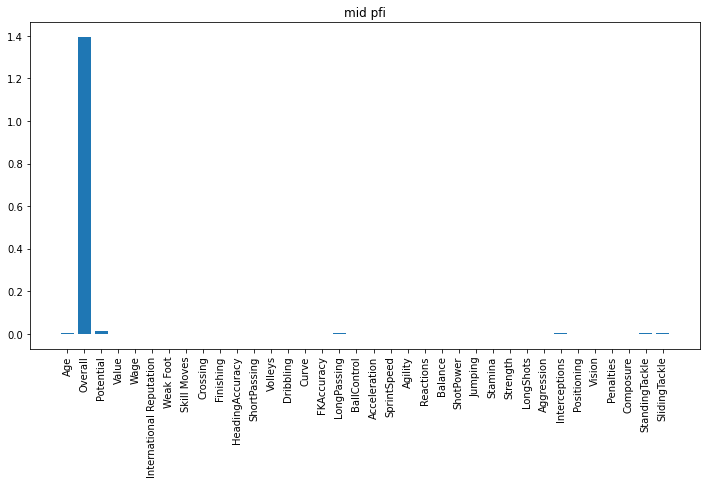

In [64]:
plot_bar_chart(mid_pfi, "mid pfi")

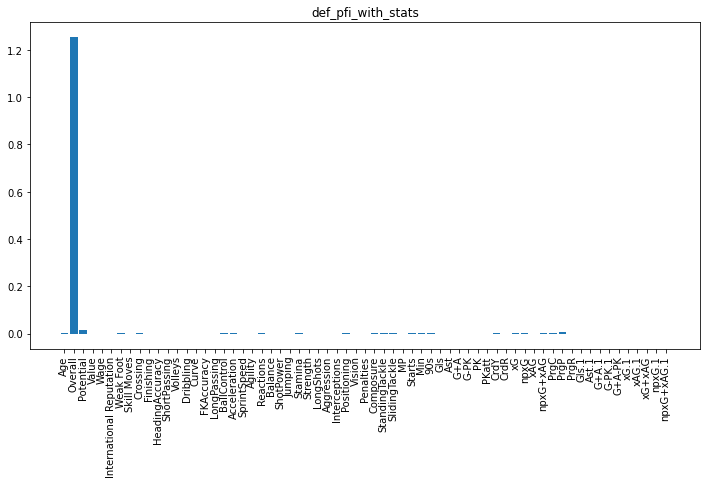

In [65]:
plot_bar_chart(def_pfi_g, "def_pfi_with_stats")

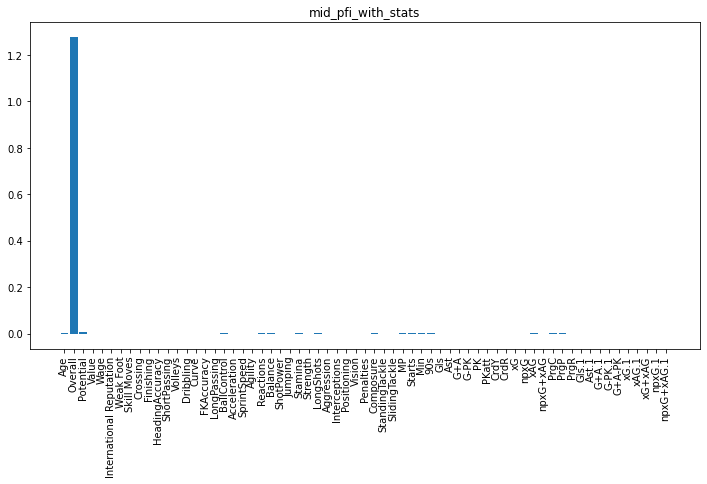

In [66]:
plot_bar_chart(mid_pfi_g, "mid_pfi_with_stats")

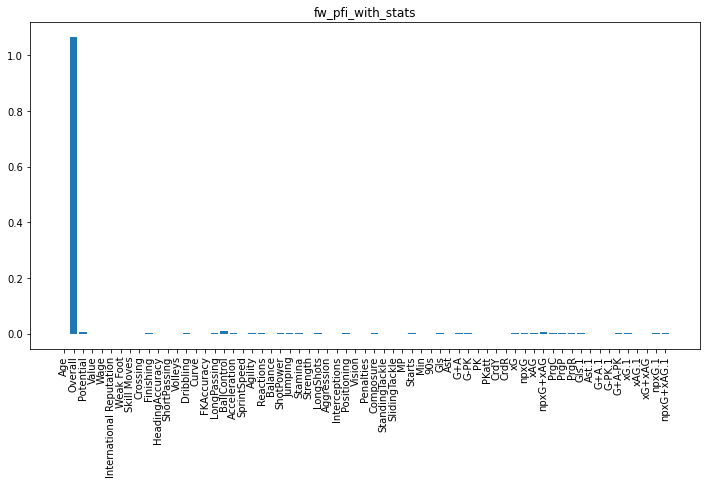

In [67]:
plot_bar_chart(fw_pfi_g, "fw_pfi_with_stats")